In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
FOLDER_PATH = "FORTH_TRACE_DATASET/part"
####Constantes
DEVICES=[1,2,3,4,5]
DEVICE_LABELS=["Pulso esquerdo","Pulso direito","Peito","Perna superior direita","Perna inferior esquerda"]

ACTIVITY_IDS=range(1,17,1)
ACTIVITY_LABELS=["Stand","Sit","Sit and Talk","Walk","Walk and Talk","Climb Stair (up/down)"
                 ," Climb Stair (up/down) and talk"," Stand-> Sit",
                 "Sit-> Stand"," Stand-> Sit and talk","Sit->Stand and talk"," Stand-> walk",
                 " Walk-> stand","Stand -> climb stairs (up/down), stand -> climb stairs (up/down) and talk",
                 "Climb stairs (up/down) -> walk"," Climb stairs (up/down) and talk -> walk and talk"]


COLUMNS_ACCELEROMETER=["accelerometer_x","accelerometer_y","accelerometer_z"]
COLUMNS_GYROSCOPE=["gyroscope_x","gyroscope_y","gyroscope_z"]
COLUMNS_MAGNETOMETER=["magnetometer_x","magnetometer_y","magnetometer_z"]

COLUMNS_MODULE=["magnetometer_module","gyroscope_module","accelerometer_module"]

# Tp1 - parte 1 

## 2.
Elabore uma rotina que carregue os dados relativos a um indivíduo e
 os devolva num Array NumPy.

In [2]:
def loadIndividual(participantId):
    indData=pd.DataFrame([])
    for device_id in DEVICES:
        df = pd.read_csv(f"{FOLDER_PATH}{participantId}/part{participantId}dev{device_id}.csv")  # just to read
        columns = [
            "device_id",
            "accelerometer_x", "accelerometer_y", "accelerometer_z",
            "gyroscope_x", "gyroscope_y", "gyroscope_z",
            "magnetometer_x", "magnetometer_y", "magnetometer_z",
            "timestamp",
            "actitivy_label"
        ]

        
        df = pd.DataFrame(df.to_numpy(), columns=columns)
    
        df["participant_id"]=participantId
        indData=pd.concat([indData,df])
    return indData

##load every participants
number_of_participants=14
dataset=pd.DataFrame([])
for i in range(number_of_participants+1):    
    indData=loadIndividual(i)
    dataset=pd.concat([indData,dataset])

In [10]:
dataset.shape

(3930798, 13)

### 3.1
Elabore uma rotina que apresente simultaneamente o
 boxplot de cada atividade

In [3]:

def add_module(col,dataset,name):
    module=np.sqrt(np.sum(dataset[col]**2,axis=1))
    dataset[name]=module

    
add_module(COLUMNS_MAGNETOMETER,dataset,"magnetometer_module")
add_module(COLUMNS_GYROSCOPE,dataset,"gyroscope_module")
add_module(COLUMNS_ACCELEROMETER,dataset,"accelerometer_module")

### 3.2

In [ ]:
def calc_outliers(col,dataset,scaling_factor):    
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - scaling_factor * IQR
    upper_limit = Q3 + scaling_factor * IQR
    
#    print(f"Limite inferior: {lower_limit}")
 #   print(f"Limite superior: {upper_limit}")
    
    
    mask_outliers = (dataset[col] <lower_limit) | (dataset[col] > upper_limit)

    densidade=np.sum(mask_outliers)/len(dataset)*100
  #  print(densidade)
    return densidade,mask_outliers

### 3.4


In [ ]:
def z_score(data):
    mean = np.mean(data) 
    std_dev = np.std(data)  
    #zscore mede a quantos desvios padrões um determinado ponto está
    z_scores = (data - mean) / std_dev  
    return z_scores,mean,std_dev

def identify_outliers_z_score(data,k):
    z_scores,mean,std_dev=z_score(data)
    return np.abs(z_scores) > k, mean,std_dev


### 3.6 


In [ ]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.patches as mpatches

# Supondo que você já tem: dataset, DEVICES, DEVICE_LABELS, COLUMNS_MODULE
n_sensors = min(len(DEVICES), 5)

# Para 2 sensores por linha, calcular número de linhas
n_cols = 2
n_rows = int(np.ceil(n_sensors / n_cols))

# Cria figura
fig = plt.figure(figsize=(12, 5 * n_rows))

# GridSpec com uma coluna extra para centralizar última linha se necessário
gs = GridSpec(n_rows, n_cols, figure=fig)

for i, sensor in enumerate(DEVICES[:n_sensors]):
    row = i // n_cols
    col = i % n_cols

    # Se for última linha com apenas 1 sensor, centraliza visualmente
    if (row == n_rows - 1) and (n_sensors % n_cols == 1):
        # criar subplot ocupando metade da largura da figura
        ax = fig.add_subplot(gs[row, 0:2], projection='3d')
    else:
        ax = fig.add_subplot(gs[row, col], projection='3d')

    # Subset dos dados
    sensordata = dataset[dataset["device_id"] == sensor]
    modules = sensordata[COLUMNS_MODULE].to_numpy()

    # KMeans
    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(modules)
    centroids = kmeans.cluster_centers_

    # Scatter dos pontos
    ax.scatter(
        modules[:, 0], modules[:, 1], modules[:, 2],
        c=labels, cmap='tab20', s=20, alpha=0.6
    )

    # Centrôides
    ax.scatter(
        centroids[:, 0], centroids[:, 1], centroids[:, 2],
        c='black', s=150, marker='X'
    )

    # Legenda no canto superior esquerdo, vertical e pequena
    unique_labels = np.unique(labels)
    colors = [plt.cm.tab20(l / 10) for l in unique_labels]
    legend_patches = [mpatches.Patch(color=c, label=f'Cluster {l}') 
                      for l, c in zip(unique_labels, colors)]

    ax.legend(
        handles=legend_patches,
        loc='upper left',
        fontsize=6,
        ncol=1,
        frameon=True,
        framealpha=0.9
    )

    # Labels e título
    ax.set_xlabel(COLUMNS_MODULE[0], labelpad=8)
    ax.set_ylabel(COLUMNS_MODULE[1], labelpad=8)
    ax.set_zlabel(COLUMNS_MODULE[2], labelpad=8)
    ax.set_title(f'KMeans - {DEVICE_LABELS[i]}', pad=20)

# Ajustes finais
plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=3.5)
plt.subplots_adjust(top=0.92, bottom=0.05, left=0.05, right=0.95)
plt.show()


In [ ]:

dataset["Cluster"] = kmeans.labels_
percentual = pd.crosstab(dataset['Cluster'], dataset['actitivy_label'], normalize='index') * 100


In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    percentual,
    annot=True,      
    fmt=".1f",         
    cmap="Blues",     
    cbar_kws={'label': 'Percentual (%)'}
)

plt.title("Distribuição de Actlabel dentro de cada Cluster (K-Means)")
plt.ylabel("Cluster")
plt.xlabel("Actlabel")
plt.tight_layout()
plt.show()

### 3.8 

In [ ]:
def inject_outliers(data, x, k, z):
    data = np.array(data, dtype=float)

    # Force 2D
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # define os limites originais e identifica outliers originais
    are_outliers, mean, std_dev = identify_outliers_z_score(data, k=3)
    
    n_total = len(are_outliers)
    n_outliers = np.sum(are_outliers)
    d = (n_outliers / n_total) * 100  # percentagem de outliers

    print(f"Density of outliers: {d}% | Desired outliers: {x}%")

    # Se já temos mais outliers do que o desejado, não injeta, mas retorna a máscara
    if d >= x:
        z_scores = (data - mean) / std_dev  
        mask_outliers = np.abs(z_scores)>k
        return mask_outliers

    # Calcula quantos novos outliers são necessários
    ratio_missing_outliers = (x - d) / 100
    non_outlier_idx = np.where(~are_outliers)[0] # devolve o indice
    n_new_points = int(round(ratio_missing_outliers * n_total))

    # Sorteia índices para injetar os outliers
    new_idx = np.random.choice(non_outlier_idx, n_new_points, replace=False)
    s = np.random.choice([-1, 1], size=(n_new_points, 1))
    q = np.random.uniform(0, z, size=(n_new_points, 1))
    u = np.mean(data, axis=0)
    dev = np.std(data, axis=0)
    data[new_idx] = u + s * k * (dev + q)

    # Calcula a máscara final usando os limites originais
    z_scores = (data - mean) / std_dev  
    mask_outliers = np.abs(z_scores)>k


    n_outliers_final = np.sum(mask_outliers)
    d_final = (n_outliers_final / n_total) * 100
    print(f"Final percentagem de outliers (usando limites originais): {d_final}%")

    return mask_outliers,data


### 3.9
Implemente o modelo linear


In [ ]:
class LinearRegression:
    def __init__(self,x,y):
        self.x=x
        self.y=y
        self.betas = np.zeros((x.shape[1]+1, 1)) #+1 é o intercept
        self.losses=[]

    def compute_mse(self,x, y):
        #intercepts
        X_b = np.c_[np.ones((x.shape[0], 1)), x]
        y_pred = X_b @ self.betas
        errors = y_pred - y
        mse = np.sum(errors ** 2) / (2 * len(y)) 
        return mse


    def fit(self):
            # Adiciona coluna de 1’s para o intercepto
            X_b = np.c_[np.ones((self.x.shape[0], 1)), self.x]
            # Solução direta (equação normal) 
            beta_full = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ self.y
            self.betas = beta_full

            return self.betas


    def predict(self, x):
        # Predição em escala normalizada
        X_b = np.c_[np.ones((x.shape[0], 1)), x]
        y_pred = X_b @ self.betas       
        return y_pred
    



### 3.10


In [ ]:
#selecionar atividade e sensor
sensor1 = dataset.loc[
    (dataset["device_id"] == DEVICES[0]) & (dataset["actitivy_label"] == 1),
    "accelerometer_module"
].to_numpy()
sensor1original=sensor1.copy()

In [ ]:
#gerar janelas
def create_sliding_window(data, p):
    assert isinstance(data, np.ndarray), "Erro: 'data' deve ser um numpy.ndarray."
    X, y = [], []
    for i in range(len(data) - p):
        X.append(data[i:i+p])
        y.append(data[i+p])
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
#gcv
def gcv_linear_regression(X, y):
    n, p = X.shape
    # Certifique-se de que X já contém a coluna de uns para o intercepto,
    # caso contrário 'p' não será o traço(H).

    model = LinearRegression()
    model.fit(X,y)
    
    y_pred = model.predict(X)
    residuals = y.flatten() - y_pred.flatten()
    rss = np.sum(residuals**2) # Residual Sum of Squares (RSS)
    
    
    XtX_inv = np.linalg.inv(X.T @ X)
    hat_matrix_trace = np.sum((X @ XtX_inv) * X)
    
    gcv = rss / (1 - hat_matrix_trace / n)**2


    return gcv, model

In [ ]:
gcv_scores = []
max_p = range(1,300,3)

data = dataset.loc[
    (dataset["device_id"] == DEVICES[0]) & (dataset["actitivy_label"] == 1),
    "accelerometer_module"
].copy()

for p in max_p:
    print(p)
    X, y_target = create_sliding_window(data.to_numpy(), p)
    gcv, model = gcv_linear_regression(X, y_target)
    gcv_scores.append(gcv)
    

#Janela ótima
optimal_window = max_p[np.argmin(gcv_scores)]
print(f"Janela ótima via GCV: {optimal_window}")


plt.plot(max_p, gcv_scores, marker='o')
plt.xlabel("Tamanho da janela")
plt.ylabel("GCV")
plt.title("Seleção da janela ótima via GCV")
plt.grid(True)
plt.show()

Criaçao das janelas de outliers

In [58]:
#### 
p=171 #janela otima

sensor1_original=sensor1.copy()
are_outliers,sensor1=inject_outliers(sensor1,10,3,1)
are_outliers[:p] = False                     # primeiros p pontos
#are_outliers[-p:] = False                    # últimos p pontos

sensor_outliers=sensor1.copy()
X, y = [], []
index_outliers=[]
for i, is_outlier in enumerate(are_outliers):
    if is_outlier:
        # Janela dos p pontos anteriores
        window = sensor1[i-p : i]
        X.append(window.flatten())
        y.append(sensor1[i])
        index_outliers.append(i)

X, y = np.array(X), np.array(y).reshape(-1, 1)


Density of outliers: 2.1596672551859126% | Desired outliers: 10%
Final percentagem de outliers (usando limites originais): 10.0001983772739%


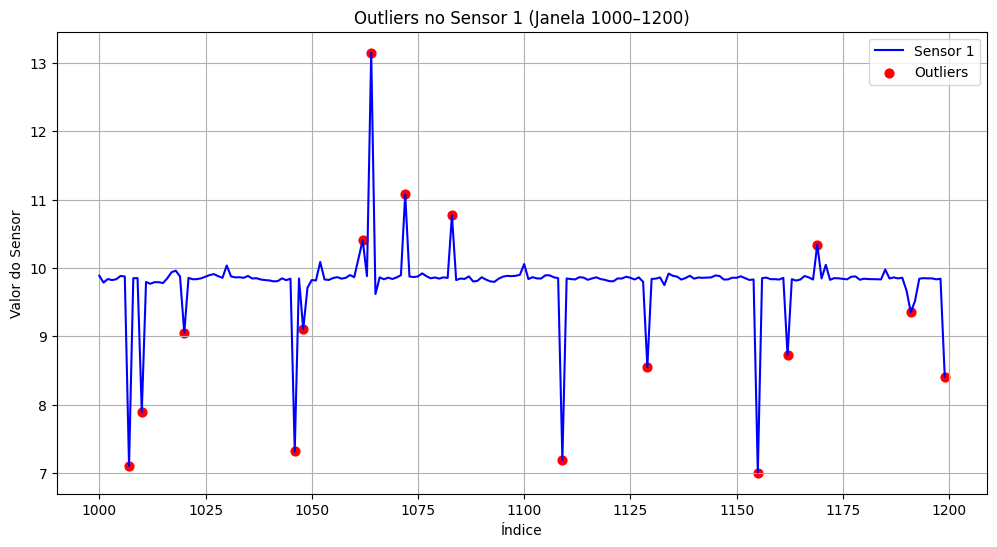

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Converter para array e garantir dimensões corretas
sensor1_array = np.array(sensor_outliers).flatten()
index_outliers = np.array(index_outliers, dtype=int)

# Janela desejada
start, end = 1000, 1200

# Filtrar outliers dentro dessa janela
mask = (index_outliers >= start) & (index_outliers < end)
idx_window = index_outliers[mask]

plt.figure(figsize=(12, 6))

# Linha azul: dados na janela
plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')

# Pontos vermelhos: outliers dentro da janela
plt.scatter(idx_window,
            sensor1_array[idx_window],
            color='red', s=40, label='Outliers')

plt.title(f"Outliers no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()

Usar o modelo previsto para corrigir outliers

In [60]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

for idx, pred in zip(index_outliers, y_pred):   
    sensor1[idx] = pred


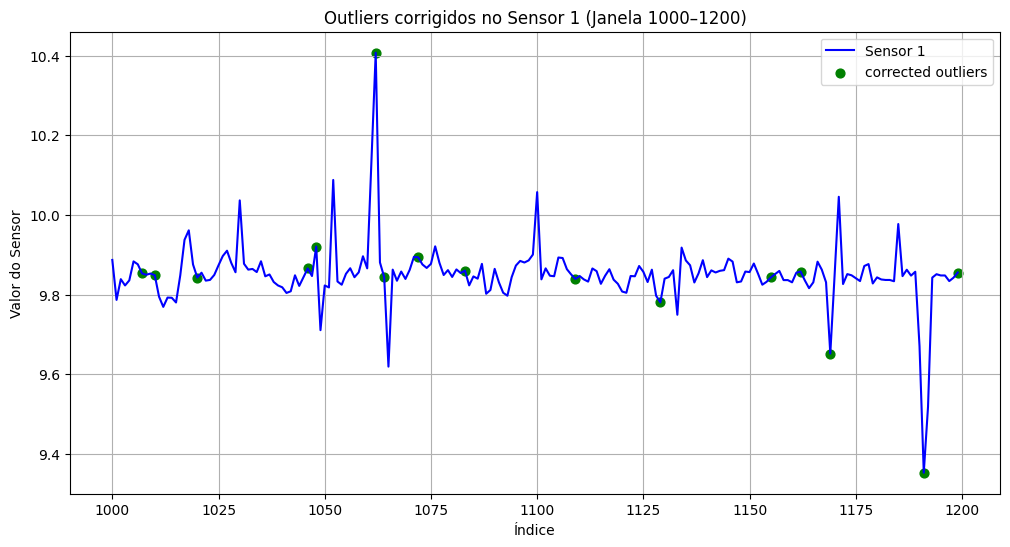

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Converter para array e garantir dimensões corretas
sensor1_array = np.array(sensor1_original).flatten()
index_outliers = np.array(index_outliers, dtype=int)

# Janela desejada
start, end = 1000, 1200

# Filtrar outliers dentro dessa janela
mask = (index_outliers >= start) & (index_outliers < end)
idx_window = index_outliers[mask]

plt.figure(figsize=(12, 6))

# Linha azul: dados na janela
plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')

# Pontos vermelhos: outliers dentro da janela
plt.scatter(idx_window,
            sensor1_array[idx_window],
            color='green', s=40, label='corrected outliers')

plt.title(f"Outliers corrigidos no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()



Distribuição do erro


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Converter tudo em arrays
sensor1original = np.array(sensor1original).flatten()
sensor1 = np.array(sensor1).flatten()
y_pred = np.array(y_pred).flatten()
index_outliers = np.array(index_outliers, dtype=int)

# Calcular erro apenas nos pontos de outliers
valid_mask = index_outliers < len(sensor1original)
index_outliers = index_outliers[valid_mask]
erros = y_pred[valid_mask] - sensor1original[index_outliers]

# Plotar distribuição (histograma + curva de densidade)
plt.figure(figsize=(10, 5))
plt.hist(erros, bins=40, color="skyblue", edgecolor="black", alpha=0.7, density=True)
plt.title("Distribuição do Erro (y_pred - y_real)")
plt.xlabel("Erro de previsão")
plt.ylabel("Densidade")
plt.grid(True)
plt.show()

# Mostrar estatísticas básicas
print(f"Erro médio: {np.mean(erros):.4f}")
print(f"Desvio padrão do erro: {np.std(erros):.4f}")
print(f"Erro absoluto médio (MAE): {np.mean(np.abs(erros)):.4f}")


Erro médio: 0.0685
Desvio padrão do erro: 1.3542
Erro absoluto médio (MAE): 1.0813

### 3.11


In [ ]:
# Seleciona apenas o device e a atividade desejada
dev1_act1 = dataset.loc[
    (dataset["device_id"] == DEVICES[0]) &
    (dataset["actitivy_label"] == 1),
    COLUMNS_MODULE
].copy()

dev1_act1_original=dev1_act1.copy()

In [64]:
def create_centered_window(data, target_col, p):
    """
    Cria janelas centradas multivariadas de forma eficiente (usando NumPy).
    
    data: pandas.DataFrame
    target_col: nome da coluna alvo
    p: tamanho total da janela (ímpar recomendado)
    """
    data_np = data.to_numpy()
    cols = list(data.columns)
    target_idx = cols.index(target_col)
    half = p // 2

    n, d = data_np.shape
    X, y, idx = [], [], []

    for i in range(half, n - half):
        # janela da variável alvo (sem o valor central)
        target_window = np.concatenate([
            data_np[i-half:i, target_idx],
            data_np[i+1:i+half+1, target_idx]
        ])
        # janelas das outras variáveis (todas as colunas exceto alvo)
        other_window = data_np[i-half:i+half+1, [j for j in range(d) if j != target_idx]].flatten()

        # concatena tudo e adiciona à lista
        X.append(np.concatenate([target_window, other_window]))
        y.append(data_np[i, target_idx])
        idx.append(data.index[i])  # salva o índice original


    return np.array(X), np.array(y), np.array(idx)


In [ ]:
#descobrir a janela P "otima" com o GCV
gcv_scores = []
max_p = range(1,300,3)

dev1_act1

for p in max_p:
    print(p)
    X, y_target = create_centered_window(dev1_act1,"accelerometer_module",p)
    gcv, model = gcv_linear_regression(X, y_target)
    gcv_scores.append(gcv)
    

#Janela ótima
optimal_window = max_p[np.argmin(gcv_scores)]
print(f"Janela ótima via GCV: {optimal_window}")


plt.plot(max_p, gcv_scores, marker='o')
plt.xlabel("Tamanho da janela")
plt.ylabel("GCV")
plt.title("Seleção da janela ótima via GCV")
plt.grid(True)
plt.show()

In [ ]:
####  treinar modelo linear e prever os outliers

p=274 #janela otima
dev1_act1_outliers=dev1_act1.copy()
dev1_act1_original=dev1_act1.copy()
X, y,_ = create_centered_window(dev1_act1_original,"accelerometer_module",p) #fazer para todos os pontos
model = LinearRegression()
model.fit(X,y)



are_outliers,dev1_act1_outliers["accelerometer_module"]=inject_outliers(dev1_act1_outliers["accelerometer_module"],10,3,1)
are_outliers[:p] = False                     # primeiros p pontos
are_outliers[-p:] = False                    # últimos p pontos

X, y_target,idx = create_centered_window(dev1_act1_outliers,"accelerometer_module",p) #fazer para todos os pontos
y_pred = model.predict(X)



are_outliers = are_outliers.flatten()

# Itera sobre cada índice central e substitui se for outlier
count = 0
for i, index in enumerate(idx):
    if are_outliers[index]:
        dev1_act1.loc[index, "accelerometer_module"] = y_pred[i]
        count += 1

print(f"Substituídos {count} outliers em {len(y_pred)} previsões válidas.")

Density of outliers: 2.6344501973853873% | Desired outliers: 10%
Final percentagem de outliers (usando limites originais): 10.0001983772739%
✅ Substituídos 13742 outliers em 150953 previsões válidas.


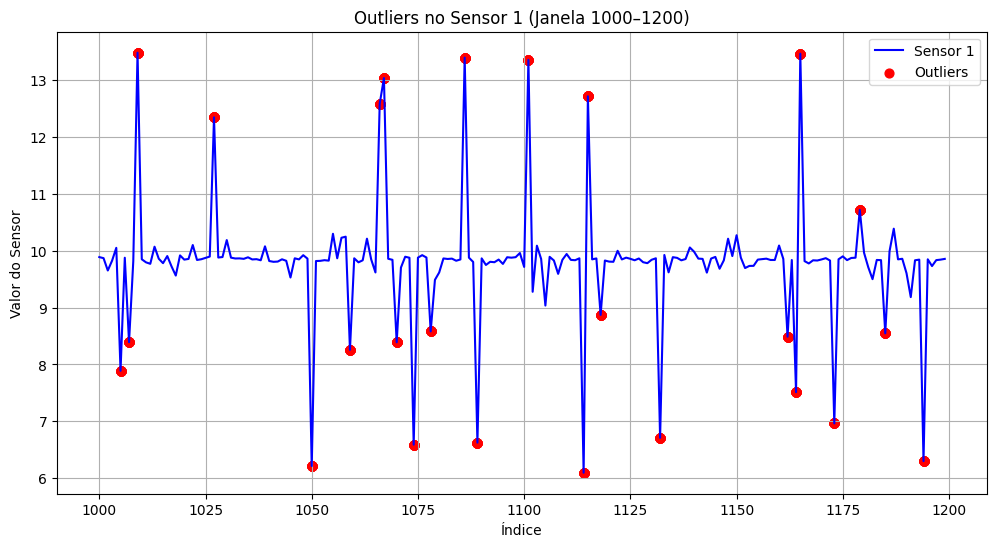

In [88]:
# mostrar outliers
sensor1_array = np.array(dev1_act1_outliers["accelerometer_module"]).flatten()
# Janela desejada
start, end = 1000, 1200

# Filtrar outliers dentro dessa janela
mask = (index_outliers >= start) & (index_outliers < end)
idx_window = index_outliers[mask]

plt.figure(figsize=(12, 6))

# Linha azul: dados na janela
plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')

# Pontos vermelhos: outliers dentro da janela
plt.scatter(idx_window,
            sensor1_array[idx_window],
            color='red', s=40, label='Outliers')

plt.title(f"Outliers no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()

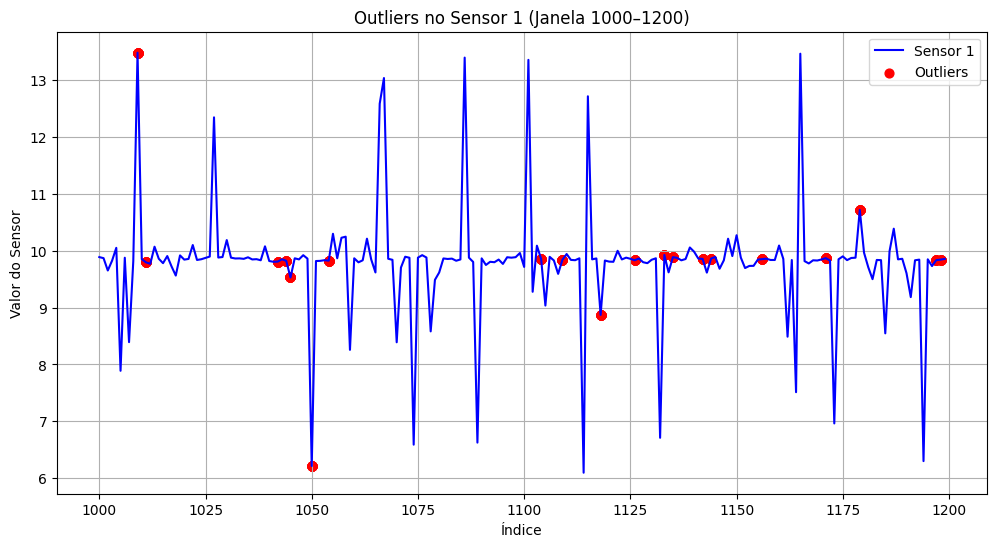

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Converter para array e garantir dimensões corretas
sensor1_array = np.array(dev1_act1_outliers["accelerometer_module"]).flatten()
index_outliers = np.array(index_outliers, dtype=int)

# Janela desejada
start, end = 1000, 1200

# Filtrar outliers dentro dessa janela
mask = (index_outliers >= start) & (index_outliers < end)
idx_window = index_outliers[mask]

plt.figure(figsize=(12, 6))

# Linha azul: dados na janela
plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')

# Pontos vermelhos: outliers dentro da janela
plt.scatter(idx_window,
            sensor1_array[idx_window],
            color='red', s=40, label='Outliers')

plt.title(f"Outliers no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()

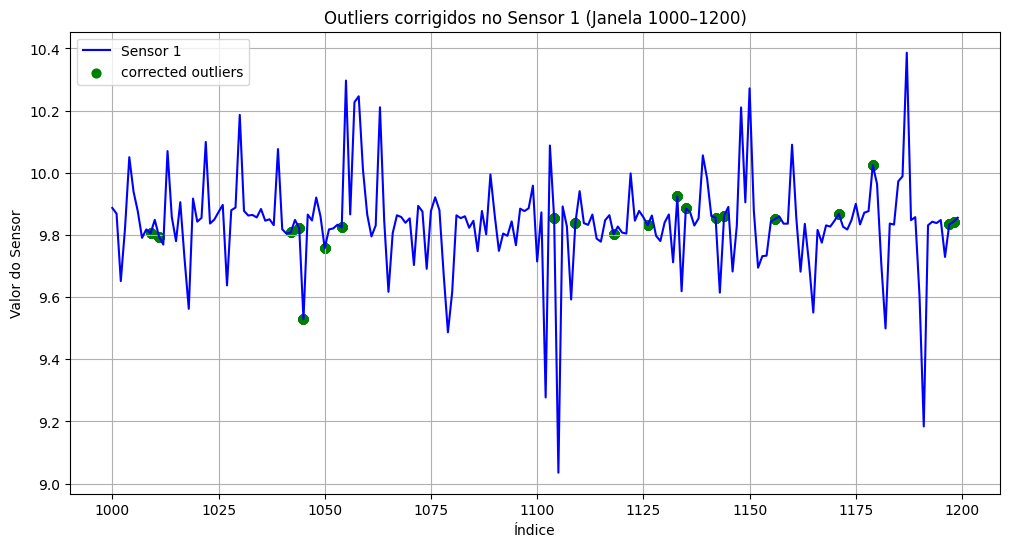

In [68]:
sensor1_array = np.array(dev1_act1["accelerometer_module"]).flatten()

start, end = 1000, 1200

mask = (index_outliers >= start) & (index_outliers < end)
idx_window = index_outliers[mask]

plt.figure(figsize=(12, 6))

plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')

plt.scatter(idx_window,
            sensor1_array[idx_window],
            color='green', s=40, label='corrected outliers')

plt.title(f"Outliers corrigidos no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()

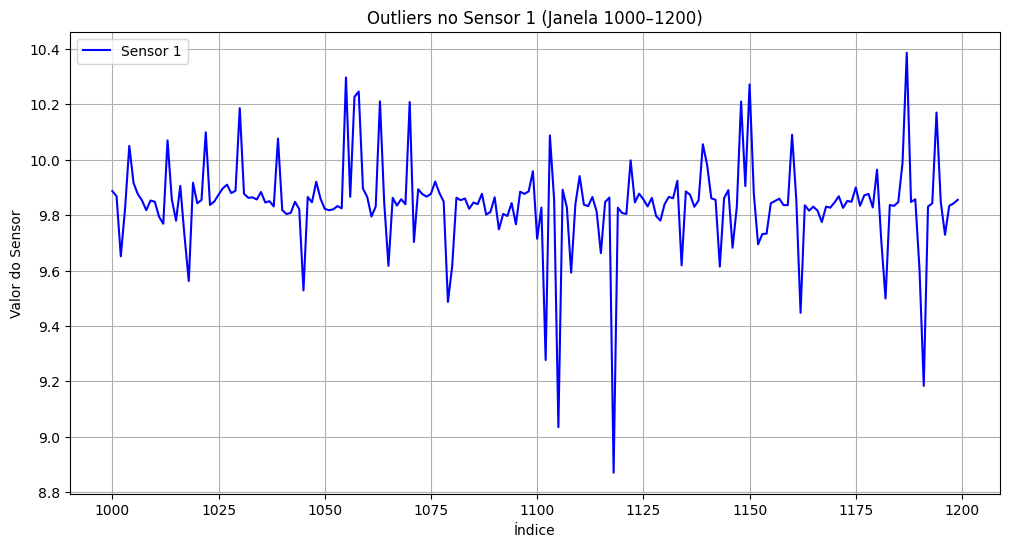

In [ ]:
#mostrar scatterplot de original
sensor1_array = np.array(dev1_act1_original["accelerometer_module"]).flatten()
index_outliers = np.array(index_outliers, dtype=int)

# Janela desejada
start, end = 1000, 1200


plt.figure(figsize=(12, 6))

# Linha azul: dados na janela
plt.plot(range(start, end),
         sensor1_array[start:end],
         color='blue', label='Sensor 1')


plt.title(f"Outliers no Sensor 1 (Janela {start}–{end})")
plt.xlabel("Índice")
plt.ylabel("Valor do Sensor")
plt.legend()
plt.grid(True)
plt.show()

Graficos e testes

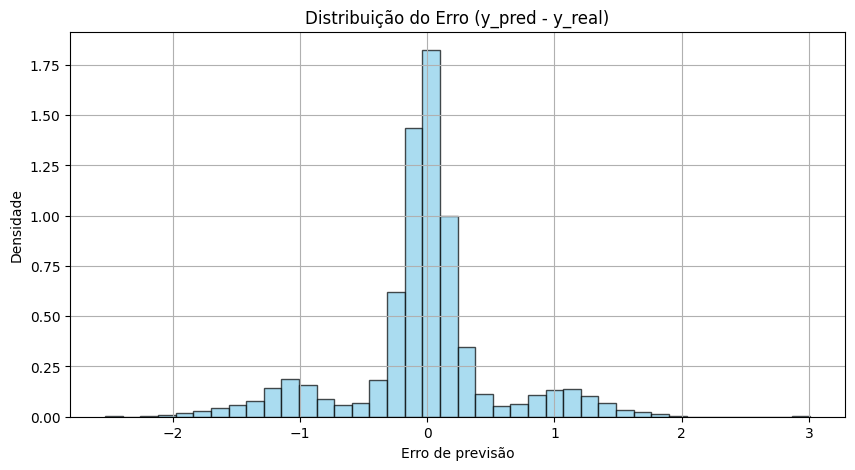

Erro médio: -0.0314
Desvio padrão do erro: 0.5771
Erro absoluto médio (MAE): 0.3612


In [ ]:
# Distribuição do erro
y_real = np.array(dev1_act1.iloc[index_outliers]["accelerometer_module"]).flatten()
y_pred_outliers = np.array([y_pred[i] for i, index in enumerate(idx) if are_outliers[index]])

errors = y_pred_outliers.flatten() - y_real


plt.figure(figsize=(10, 5))
plt.hist(errors, bins=40, color="skyblue", edgecolor="black", alpha=0.7, density=True)
plt.title("Distribuição do Erro (y_pred - y_real)")
plt.xlabel("Erro de previsão")
plt.ylabel("Densidade")
plt.grid(True)
plt.show()

# Mostrar estatísticas básicas
print(f"Erro médio: {np.mean(errors):.4f}")
print(f"Desvio padrão do erro: {np.std(errors):.4f}")
print(f"Erro absoluto médio (MAE): {np.mean(np.abs(errors)):.4f}")


# 4 
Analise dos dados dos sensores
Existem atividade repetidas em momentos diferentes

In [93]:
import pandas as pd

# criar dicionários para armazenar resultados
dist_summary_sensors = {}
percent_erros_sensors = {}

# pegar todos os device_id únicos
part1=dataset[dataset["participant_id"]==1]
devices = part1["device_id"].unique()

for dev_id in devices:
    # filtrar dados do sensor
    dev = part1[part1["device_id"] == dev_id]
    # calcular diferenças de timestamp
    diffs = dev["timestamp"].diff()
    
    # substituir o NaN inicial pela mediana
    diffs.iloc[0] = 20
    
    # tabela de frequência
    dist_table = diffs.value_counts().sort_index()
    dist_percent = (dist_table / dist_table.sum() * 100).round(2)
    
    dist_summary = pd.DataFrame({
        "count": dist_table,
        "percent": dist_percent
    })
    
    dist_summary_sensors[dev_id] = dist_summary
    
    # percentagem de erros fora da faixa [19, 21]
    erros = diffs[(diffs < 19) | (diffs > 21)]
    percent_erros = len(erros) / len(diffs) * 100
    percent_erros_sensors[dev_id] = percent_erros



with pd.ExcelWriter("sensor_stats.xlsx") as writer:
    for dev_id, df in dist_summary_sensors.items():
        # calcular erro total fora da faixa [19, 21]
        diffs = dataset[dataset["device_id"] == dev_id]["timestamp"].diff().dropna()
        diffs.iloc[0] = diffs.median()
        erro_total = ((diffs < 19) | (diffs > 21)).sum()
        erro_percent = ((diffs < 19) | (diffs > 21)).sum() / len(diffs) * 100
        
        # criar cópia para salvar
        df_to_save = df.copy()
        
        # adicionar a linha de erro logo a seguir à tabela
        df_to_save.loc["Erro_Total"] = [erro_total, round(erro_percent, 2)]
        
        # salvar aba no Excel
        df_to_save.to_excel(writer, sheet_name=f"Device_{dev_id}")

print("Excel gerado com sucesso: sensor_stats.xlsx")



Excel gerado com sucesso: sensor_stats.xlsx


Sensor 5 e sensor3

In [95]:
dev = part1[part1["device_id"] == 3]

# calcular diferença temporal entre amostras consecutivas
diffs = dev["timestamp"].diff()

# definir limiar — por exemplo, saltos > 50 ms (mais de 2× o esperado)
mask_jumps = diffs > 100

# obter os índices onde ocorreram os saltos
jump_indices = diffs[mask_jumps].index
print(f"Encontrados {len(jump_indices)} saltos.")

Encontrados 1 saltos.


In [96]:
# escolher um salto (exemplo: o primeiro)
jump_idx = jump_indices[0]

# mostrar 2 linhas antes e 2 depois do salto
print(dev.loc[jump_idx - 2:jump_idx + 2, ["timestamp"]])

       timestamp
24789   485790.0
24790   485810.0
24791   492620.0
24792   492640.0
24793   492660.0


Para o sensor 3 existem um salto no csv part1dev3.csv da linha 24792 para 24793 do csv

Identificamos por volta de 10%-20% para cada sensor de erros abaixo de 19 e acima de 21 ms
Nomeadamente diferenças de 10,39,40 e 100ms
Estes erros irao acumular e criar janelas incoerentes, especialmente se quisermos integrar varios sensores para classificar uma atividade. Estariamos a introduzir ruido.
Justificando assim a escolha de fazer ressampling


Percentagem de erros de amostragem (fora de 19–21 ms): 7.73%


Como sensor com taxa de amostragem de 50hz (ou 20ms), apresenta corretamente uma mediana da taxa de 20 ms, mas o maximo valor de 185000ms é um erro/outlier?- Assumimos x

### 4.2

In [5]:
from scipy.stats import skew
import itertools


def spectral_entropy(signal):
    # FFT
    fft_vals = np.fft.fft(signal)
    psd = np.abs(fft_vals) ** 2  # densidade espectral de potência
    psd = psd[:len(psd)//2]      # usa apenas metade positiva
    
    # Normalizar PSD para formar distribuição de probabilidade
    psd_sum = np.sum(psd)
    if psd_sum == 0:
        return 0.0  # evita divisão por zero (sinal nulo)
    psd_norm = psd / psd_sum
    
    # Entropia de Shannon
    H = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # +1e-12 para evitar log(0)
    
    # Normalizar para [0, 1]
    H_norm = H / np.log2(len(psd_norm))
    
    return H_norm


def create_statistics_features(data,col):
    mean = data[col].mean()
    median=data[col].median()
    std = data[col].std()
    variance=data[col].var()
    root_mean_square=np.sqrt(np.mean(data[col]**2))
    derivate=np.mean(np.diff(data[col]))
    skewness=skew(data[col])
    kurtosis=data[col].kurtosis()
    q1 = np.percentile(data[col], 25)
    q3 = np.percentile(data[col], 75)
    iqr = q3 - q1

    zero_crossings = np.where(np.diff(np.sign(data[col])))[0]
    zcr = len(zero_crossings) / (len(data[col]) - 1)
    mean_crossings = np.where(np.diff(np.sign(data[col] - mean)))[0]
    mcr = len(mean_crossings) / (len(data[col]) - 1)
    sp=spectral_entropy(data[col])
    return mean,median,std,variance,root_mean_square,derivate,skewness,kurtosis,iqr,zcr,mcr,sp



def pairwise_features(data, sensor1cols, sensor2cols):
    values = []

    # --- Intra-sensor 1 ---
    for c1, c2 in itertools.combinations(sensor1cols, 2):
        values.append(data[c1].corr(data[c2]))

    # --- Intra-sensor 2 ---
    for c1, c2 in itertools.combinations(sensor2cols, 2):
        values.append(data[c1].corr(data[c2]))

    # --- Inter-sensor ---
    for c1 in sensor1cols:
        for c2 in sensor2cols:
            values.append(data[c1].corr(data[c2]))
    return np.array(values)


def sma_accelerometer(window):
    cols = ["accelerometer_x", "accelerometer_y", "accelerometer_z"]
    sum_abs = np.sum(np.abs(window[cols]), axis=1)  # soma absoluta por amostra
    return np.mean(sum_abs)  # média sobre a janela

def movement_intensity(window):
    cols = ["accelerometer_x","accelerometer_y","accelerometer_z"]

    MI_t = np.linalg.norm(window[cols], axis=1)
    AI = np.mean(MI_t)
    VI = np.var(MI_t)
    return [AI, VI]

import numpy as np

def eva_accelerometer(window):
    cols = ["accelerometer_x", "accelerometer_y", "accelerometer_z"]
    data_matrix = window[cols].to_numpy()  # shape (p, 3)
    # Matriz de covariância 3x3
    cov_matrix = np.cov(data_matrix, rowvar=False)  
    # Autovalores
    eigenvalues = np.linalg.eigvalsh(cov_matrix)  # retorna em ordem crescente
    eigenvalues = np.sort(eigenvalues)[::-1]
    top2 = eigenvalues[:2]
    return top2

def cagh(window):
    a_x = window["accelerometer_x"].values
    a_y = window["accelerometer_y"].values
    a_z = window["accelerometer_z"].values
    
    # magnitude no plano horizontal (heading)
    a_heading = np.sqrt(a_y**2 + a_z**2)
    
    # coeficiente de correlação de Pearson
    corr_matrix = np.corrcoef(a_x, a_heading)
    cagh_val = corr_matrix[0,1]
    
    return cagh_val
def avh(window):
    y = window["accelerometer_y"].values
    z = window["accelerometer_z"].values
    
    # Velocidades médias (diferenças entre amostras)
    v_y = np.mean(np.diff(y))
    v_z = np.mean(np.diff(z))
    
    # Norma Euclidiana
    return np.sqrt(v_y**2 + v_z**2)
def avg_gravity(window, dt=0.01):

    a_x = window["accelerometer_x"].values
    
    # Integração cumulativa para obter velocidades instantâneas
    v_x = np.cumsum(a_x) * dt
    
    # Velocidade média ao longo da janela
    return np.mean(v_x)

def aratg(window):
    gyro_x = window["gyroscope_x"].values
    cumulative_rotation = np.cumsum(gyro_x)
    return np.mean(cumulative_rotation)
def dominant_frequency(window, fs=100):
    
    cols = ["accelerometer_x","accelerometer_y","accelerometer_z","gyroscope_x","gyroscope_y","gyroscope_z"]
    df_values = []
    
    for col in cols:
        signal = window[col].values
        n = len(signal)
        # FFT
        fft_vals = np.fft.fft(signal)
        fft_power = np.abs(fft_vals[:n//2])**2  # magnitude ao quadrado, só metade positiva
        freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]
        # Frequência dominante
        dominant_freq = freqs[np.argmax(fft_power)]
        df_values.append(dominant_freq)
    
    return df_values
def aae(window):

    acc_cols = ["accelerometer_x","accelerometer_y","accelerometer_z"]
    energy_vals = []

    for col in acc_cols:
        signal = window[col].values
        fft_vals = np.fft.fft(signal)
        fft_power = np.abs(fft_vals)**2
        energy_vals.append(np.sum(fft_power) / len(signal))
    
    return np.mean(energy_vals)

def are(window):
    gyro_cols = ["gyroscope_x","gyroscope_y","gyroscope_z",]
    energy_vals = []

    for col in gyro_cols:
        signal = window[col].values
        fft_vals = np.fft.fft(signal)
        fft_power = np.abs(fft_vals)**2
        energy_vals.append(np.sum(fft_power) / len(signal))
    
    return np.mean(energy_vals)

def energy(window):
    cols = ["gyroscope_x","gyroscope_y","gyroscope_z","accelerometer_x","accelerometer_y","accelerometer_z"]
    energy_values = [np.sum(np.square(window[col].values)) for col in cols]
    return np.array(energy_values)

def create_spectral_features(window):
    spectral_features = []
    spectral_features.append(sma_accelerometer(window))
    spectral_features.extend(movement_intensity(window))
    spectral_features.extend(eva_accelerometer(window))   # usar extend
    spectral_features.append(cagh(window))
    spectral_features.append(avh(window))
    spectral_features.append(avg_gravity(window))
    spectral_features.append(aratg(window))
    spectral_features.extend(dominant_frequency(window))  # usar extend
    spectral_features.extend(energy(window))              # usar extend
    spectral_features.append(aae(window))
    spectral_features.append(are(window))
    return spectral_features

def extract_features(data, p):
    features_list = []
    statistics_cols=["accelerometer_x","accelerometer_y","accelerometer_z",
            "gyroscope_x","gyroscope_y","gyroscope_z"]
    

    
    for i in range(len(data) - p):
        window = data.iloc[i:i+p]
        window_features = []
        if i%1000==0:
          print(i)
        
        # Estatísticas básicas
        for col in statistics_cols:
            feats = create_statistics_features(window, col)
            window_features.extend(feats)

        pw_feats=pairwise_features(window,["accelerometer_x","accelerometer_y","accelerometer_z"],
            ["gyroscope_x","gyroscope_y","gyroscope_z"]                           )
        window_features.extend(pw_feats)

        sp_feature=create_spectral_features(window)
        window_features.extend(sp_feature) #adiciona as features de espectro ao windo

        features_list.append(window_features)
    
    return np.array(features_list)




def extract_sensor_features(window):
    features = []
    statistical_cols = ["accelerometer_x","accelerometer_y","accelerometer_z",
                        "gyroscope_x","gyroscope_y","gyroscope_z"]
    
    # Estatísticas básicas
    for col in statistical_cols:
        feats = create_statistics_features(window, col)
        features.extend(feats)
    
    # Pairwise features
    pw_feats = pairwise_features(window, ["accelerometer_x","accelerometer_y","accelerometer_z"],
                                 ["gyroscope_x","gyroscope_y","gyroscope_z"])
    features.extend(pw_feats)
    
    # Spectral features
    sp_feats = create_spectral_features(window)
    features.extend(sp_feats)    
    return features


In [6]:
def create_time_window(sensorData, window_size, overlap):
    n_rows = len(sensorData)
    sensor_features = []

    # passo entre janelas
    step = int(window_size * (1 - overlap))
    if step < 1:
        step = 1  # garante que o passo nunca seja zero

    # Iterar pelas janelas
    for start in range(0, n_rows - window_size + 1, step):
        end = start + window_size
        window_data = sensorData.iloc[start:end]
        window_features = extract_sensor_features(window_data)  # sua função de extração
        sensor_features.append(window_features)

    return np.array(sensor_features)

In [7]:
def create_time_window(sensorData, window_duration_s, overlap, time_col="timestamp"):
    """
    Cria janelas temporais baseadas no timestamp real.
    """
    sensor_features = []

    # Ordenar por timestamp (garantia)
    sensorData = sensorData.sort_values(time_col).reset_index(drop=True)

    # Definir início e fim do tempo
    start_time = sensorData[time_col].iloc[0]
    end_time = sensorData[time_col].iloc[-1]

    # Converter duração da janela e passo
    window_ms = window_duration_s * 1000
    step_ms = window_ms * (1 - overlap)
    if step_ms < 1:
        step_ms = 1  # evita zero

    # Percorrer janelas reais
    t = start_time
    while t + window_ms <= end_time:
        window_data = sensorData[
            (sensorData[time_col] >= t) &
            (sensorData[time_col] < t + window_ms)
        ]


        if len(window_data) <10: #como lidar com isto?
            t += step_ms
            continue

        window_features = extract_sensor_features(window_data)
        sensor_features.append(window_features)

        t += step_ms

    return np.array(sensor_features)

In [8]:
participant_1_dataset=dataset[dataset["participant_id"] == 1]



In [9]:
#extrair as features para um participante somente.
window_size = 2
overlap = 0.5

all_features = []
all_devices = []
all_activities = []
participant_1_dataset=dataset[dataset["participant_id"] == 1]
for sensor in DEVICES:
    for j, activity in enumerate(ACTIVITY_LABELS):
        # Filtra os dados do sensor e atividade
        sensor_data = participant_1_dataset.loc[
            (participant_1_dataset["actitivy_label"] == j+1) & 
            (participant_1_dataset["device_id"] == sensor)
        ]   
        
        # Extrai janelas de features
        sensor_features = create_time_window(sensor_data, window_size, overlap)
        print(f"Sensor {sensor}, Activity {activity}, Shape: {sensor_features.shape}")
        all_features.append(sensor_features)
        all_devices.extend([sensor] * sensor_features.shape[0])
        all_activities.extend([activity] * sensor_features.shape[0])

all_features_array = np.vstack(all_features)  

feature_cols = [f"f{k}" for k in range(all_features_array.shape[1])]
features_dataset = pd.DataFrame(all_features_array, columns=feature_cols)
features_dataset["device_id"] = all_devices
features_dataset["activity_label"] = all_activities

print(features_dataset.head())
print("Final shape:", features_dataset.shape)



Sensor 1, Activity Stand, Shape: (208, 110)
Sensor 1, Activity Sit, Shape: (108, 110)
Sensor 1, Activity Sit and Talk, Shape: (108, 110)
Sensor 1, Activity Walk, Shape: (185, 110)
Sensor 1, Activity Walk and Talk, Shape: (193, 110)
Sensor 1, Activity Climb Stair (up/down), Shape: (121, 110)
Sensor 1, Activity  Climb Stair (up/down) and talk, Shape: (59, 110)
Sensor 1, Activity  Stand-> Sit, Shape: (8, 110)
Sensor 1, Activity Sit-> Stand, Shape: (6, 110)
Sensor 1, Activity  Stand-> Sit and talk, Shape: (8, 110)
Sensor 1, Activity Sit->Stand and talk, Shape: (6, 110)
Sensor 1, Activity  Stand-> walk, Shape: (5, 110)
Sensor 1, Activity  Walk-> stand, Shape: (13, 110)
Sensor 1, Activity Stand -> climb stairs (up/down), stand -> climb stairs (up/down) and talk, Shape: (5, 110)
Sensor 1, Activity Climb stairs (up/down) -> walk, Shape: (1, 110)
Sensor 1, Activity  Climb stairs (up/down) and talk -> walk and talk, Shape: (1, 110)
Sensor 2, Activity Stand, Shape: (215, 110)
Sensor 2, Activity S

In [12]:

# Verifique o nome exato das colunas (ajuste se necessário)
feature_cols = [c for c in features_dataset.columns if c not in ['device_id', 'activity_label']]

# Dicionário de DataFrames por sensor
sensors = {
    sid: df.drop(columns=['device_id']).reset_index(drop=True)
    for sid, df in features_dataset.groupby('device_id')
}

final_dfs = []

# Interseção das atividades comuns a todos os sensores
common_activities = set.intersection(*(set(df['activity_label']) for df in sensors.values()))

for activity in common_activities:
    # Pegar subconjuntos por atividade
    per_sensor = {
        sid: df[df['activity_label'] == activity].drop(columns=['activity_label']).reset_index(drop=True)
        for sid, df in sensors.items()
    }

    # Número mínimo de janelas entre sensores (sincronização)
    min_len = min(len(df) for df in per_sensor.values())
    if min_len == 0:
        continue

    # Cortar e concatenar horizontalmente
    combined = np.hstack([per_sensor[sid].iloc[:min_len, :].values for sid in sorted(per_sensor.keys())])

    # Gerar nomes de colunas
    colnames = [f"{c}_s{sid}" for sid in sorted(per_sensor.keys()) for c in feature_cols]

    df_final = pd.DataFrame(combined, columns=colnames)
    df_final['activity_id'] = activity
    final_dfs.append(df_final)

# Concatenar tudo
joined_dataset = pd.concat(final_dfs, ignore_index=True)

print("Final joined shape:", joined_dataset.shape)
joined_dataset.head()


Final joined shape: (973, 551)


,f0_s1,f1_s1,f2_s1,f3_s1,f4_s1,f5_s1,f6_s1,f7_s1,f8_s1,f9_s1,...,f101_s5,f102_s5,f103_s5,f104_s5,f105_s5,f106_s5,f107_s5,f108_s5,f109_s5,activity_id
0,-0.058371,-0.18567,2.212446,4.894918,2.202454,0.015059,0.170980,-0.843054,3.549150,0.058824,...,0.970874,3516.079895,3331.447232,12513.924067,746.005569,8445.124747,736.685404,3309.271906,6453.817065,Sit-> Stand
1,-0.055550,-1.06450,1.856406,3.446243,1.848207,-0.033127,1.002238,-0.264043,2.543300,0.049020,...,0.000000,2240.383932,1481.927966,9205.239065,428.332589,8430.629067,775.962852,3211.641503,4309.183654,Sit-> Stand
2,-1.409227,-1.39855,0.307314,0.094442,1.442026,-0.000393,0.192830,-0.257037,0.447700,0.000000,...,0.000000,318.169222,1219.875143,2491.307721,292.527773,8390.468711,935.002468,3205.999651,1343.117362,Sit-> Stand
3,-1.463075,-1.46055,0.278658,0.077650,1.489119,-0.003904,0.258783,-0.247392,0.404825,0.000000,...,0.980392,192.957448,872.849504,1160.484698,313.538627,8361.905783,941.048220,3205.497543,742.097217,Sit-> Stand
4,-1.529652,-1.50735,0.168410,0.028362,1.538804,-0.001317,-0.579093,-0.320620,0.198300,0.000000,...,0.970874,97.469522,250.321177,228.784288,292.661007,8486.150088,934.710753,3237.840616,192.191663,Sit-> Stand


In [128]:
features_dataset.to_csv("features_dataset_p1.csv",index=False)

### 4.3 PCA

In [ ]:
df_features=pd.read_csv("features_dataset_p1.csv")

In [7]:
def pca(X, n_components=110):
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # Calcular a matriz de covariância
    cov_mat = np.cov(X_normalized, rowvar=False)
    
    # Calcular autovalores e autovetores
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
    # Ordenar por autovalores decrescentes
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]    
    # Selecionar os n componentes principais
    eigenvectors_subset = eigenvectors[:, :n_components]
    
    # Projetar os dados
    X_reduced = np.dot(X_normalized, eigenvectors_subset)
    
    return X_reduced, eigenvalues, eigenvectors

In [ ]:

dev1_act1=df_features[(df_features["device_id"] == 1) & (df_features["activity_label"] == "Walk")]
X = dev1_act1.iloc[:, :-2].values      # todas as colunas menos as últimas 2
info_cols = dev1_act1.iloc[:, -2:]     # últimas 2 colunas (sensor, atividade)
X_pca, eigenvalues, eigenvectors = pca(X, n_components=110)

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

df_pca = pd.concat([df_pca, info_cols.reset_index(drop=True)], axis=1)

In [24]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

# Variância acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

# Exibe
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var*100:.2f}% da variância")

print("\nVariância acumulada:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1 a PC{i+1}: {cum_var*100:.2f}%")



PC1: 17.50% da variância
PC2: 10.87% da variância
PC3: 8.10% da variância
PC4: 6.35% da variância
PC5: 4.72% da variância
PC6: 4.12% da variância
PC7: 3.43% da variância
PC8: 2.67% da variância
PC9: 2.35% da variância
PC10: 2.07% da variância
PC11: 1.97% da variância
PC12: 1.76% da variância
PC13: 1.67% da variância
PC14: 1.58% da variância
PC15: 1.42% da variância
PC16: 1.26% da variância
PC17: 1.20% da variância
PC18: 1.14% da variância
PC19: 1.08% da variância
PC20: 1.04% da variância
PC21: 0.98% da variância
PC22: 0.95% da variância
PC23: 0.89% da variância
PC24: 0.86% da variância
PC25: 0.84% da variância
PC26: 0.83% da variância
PC27: 0.81% da variância
PC28: 0.78% da variância
PC29: 0.75% da variância
PC30: 0.72% da variância
PC31: 0.69% da variância
PC32: 0.65% da variância
PC33: 0.63% da variância
PC34: 0.61% da variância
PC35: 0.58% da variância
PC36: 0.57% da variância
PC37: 0.55% da variância
PC38: 0.53% da variância
PC39: 0.50% da variância
PC40: 0.50% da variância
PC41: 0

In [25]:
n_components = 19
pca_components = eigenvectors[:, :n_components]

In [28]:

# centralizar os dados originais
print(f"instante 0: {X[0]}")
X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
print(f"instante 0 normalizado: {X_normalized[0]}")
# projetar nos 19 vetores principais
print(f"PC1 {pca_components[0]}")
X_pca_19 = np.dot(X_normalized, pca_components)
print("instante 0 projetado no pca 19: ", X_pca_19[0])

print("Forma projetada:", X_pca_19.shape)  # (n_amostras, 19)

instante 0: [-1.58410390e+00 -1.34310000e+00  8.37137852e-01  7.00799783e-01
  1.78974215e+00 -1.63804040e-02 -1.17864384e+00  1.07128629e+00
  8.26875000e-01  0.00000000e+00  1.31313131e-01  1.60082436e-01
  9.64607300e+00  9.68725000e+00  1.62964842e+00  2.65575396e+00
  9.78140689e+00 -6.28222222e-02  2.02894642e-01 -4.26378363e-01
  2.27412500e+00  0.00000000e+00  7.07070707e-02  2.62608205e-02
  2.08644250e+00  1.99645000e+00  8.33056123e-01  6.93982504e-01
  2.24505790e+00 -1.93575758e-02  3.35643606e-01 -8.01099366e-01
  1.33815000e+00  0.00000000e+00  5.05050505e-02  9.40431756e-02
 -6.02334130e+00 -6.79045000e+00  2.21864580e+01  4.92238920e+02
  2.28822458e+01  2.52969697e-02  1.24388155e-01 -8.97772513e-01
  3.17246750e+01  4.04040404e-02  4.04040404e-02  3.90418522e-01
 -6.53283200e+00 -6.53575000e+00  2.94355421e+01  8.66451140e+02
  3.00077410e+01 -4.12929293e-02  1.73592718e-01  3.98551361e-01
  2.76744500e+01  1.01010101e-01  1.21212121e-01  4.84157293e-01
 -1.89488620e

### 4.5 Fisher and reliefF

In [13]:
    
def reliefF(X, y, n_neighbors=10):
    n_samples, n_features = X.shape
    scores = np.zeros(n_features)
    
    classes, counts = np.unique(y, return_counts=True)
    P_c = {cls: count / n_samples for cls, count in zip(classes, counts)}
    
    for idx in range(n_samples):
        sample = X[idx]
        label = y[idx]
        
        dists = np.linalg.norm(X - sample, axis=1)
        dists[idx] = np.inf  # ignorar a própria amostra
        
        hits_idx = np.argsort(dists[y == label])[:n_neighbors]
        hits = X[y == label][hits_idx]
        
        for cls in classes:
            if cls == label:
                continue
            miss_idx = np.argsort(dists[y == cls])[:n_neighbors]
            misses = X[y == cls][miss_idx]
            scores += np.mean(np.abs(sample - misses), axis=0) * P_c[cls]  # aumenta importância
        scores -= np.mean(np.abs(sample - hits), axis=0)  # diminui importância
    
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    return scores


In [17]:
from sklearn.preprocessing import StandardScaler

X = joined_dataset.drop(columns=['activity_id']).values
y = joined_dataset['activity_id'].values


scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
scores = reliefF(X_scaled, y, n_neighbors=10)

feature_names = joined_dataset.drop(columns=['activity_id']).columns

relief_df = pd.DataFrame({
    'feature': feature_names,
    'score': scores
}).sort_values(by='score', ascending=False)

print(relief_df.head(20))

     feature     score
354   f24_s4  1.000000
355   f25_s4  0.993739
358   f28_s4  0.936245
138   f28_s2  0.928734
28    f28_s1  0.922702
437  f107_s4  0.913126
24    f24_s1  0.905873
197   f87_s2  0.904594
25    f25_s1  0.900881
107  f107_s1  0.900210
13    f13_s1  0.898901
217  f107_s2  0.897676
346   f16_s4  0.895499
12    f12_s1  0.895134
16    f16_s1  0.892734
343   f13_s4  0.892669
134   f24_s2  0.892202
342   f12_s4  0.891734
0      f0_s1  0.889538
126   f16_s2  0.889103


In [19]:
def fisher_score(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    classes = np.unique(y)
    n_features = X.shape[1]

    overall_mean = np.mean(X, axis=0)
    numerator = np.zeros(n_features)
    denominator = np.zeros(n_features)

    for c in classes:
        X_c = X[y == c]
        n_c = X_c.shape[0]
        mean_c = np.mean(X_c, axis=0)
        var_c = np.var(X_c, axis=0)

        numerator += n_c * (mean_c - overall_mean) ** 2
        denominator += n_c * var_c

    fisher_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

    return fisher_scores


In [20]:
from sklearn.preprocessing import StandardScaler

X = joined_dataset.drop(columns=['activity_id']).values
y = joined_dataset['activity_id'].values


scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
scores = fisher_score(X_scaled, y)

feature_names = joined_dataset.drop(columns=['activity_id']).columns

relief_df = pd.DataFrame({
    'feature': feature_names,
    'score': scores
}).sort_values(by='score', ascending=False)

print(relief_df.head(20))

     feature       score
16    f16_s1  129.902427
12    f12_s1  124.344083
107  f107_s1  112.062141
122   f12_s2  107.437246
217  f107_s2  107.171549
13    f13_s1  100.847119
126   f16_s2   97.218560
346   f16_s4   80.298049
105  f105_s1   78.559214
28    f28_s1   71.765043
123   f13_s2   71.588412
437  f107_s4   69.944939
342   f12_s4   69.730666
134   f24_s2   68.657468
138   f28_s2   66.545777
24    f24_s1   66.463568
343   f13_s4   65.199125
135   f25_s2   61.934115
25    f25_s1   61.452771
354   f24_s4   36.113846


# META B


### 1. data splitting e métricas de exatidão 


1.1

In [1]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import load_iris
import numpy as np

In [2]:

def split_data_tt(X, y, test_size=0.3, random_state=10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

def split_data_tvt(X, y, val_size=0.3, test_size=0.3, random_state=10):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def split_data_kfold(X, n_splits, random, shuffle=True):
    kf = KFold(n_splits=n_splits, random_state=random, shuffle=shuffle)
    folds = []
    for train_idx, test_idx in kf.split(X):
        folds.append((train_idx, test_idx))
    return folds

In [21]:
# Carregar dados
data = load_iris()
X, y = data.data, data.target

# 1. Train-Test Split
X_train, X_test, y_train, y_test = split_data_tt(X, y)
print("Train-Test shapes:", X_train.shape, X_test.shape)

# 2. Train-Validation-Test Split
X_train, X_val, X_test, y_train, y_val, y_test = split_data_tvt(X, y)
print("Train-Val-Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# 3. K-Fold Split
folds = split_data_kfold(X, n_splits=5, random=1)
for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i+1}: Train size={len(train_idx)}, Test size={len(test_idx)}")


Train-Test shapes: (105, 4) (45, 4)
Train-Val-Test shapes: (60, 4) (45, 4) (45, 4)
Fold 1: Train size=120, Test size=30
Fold 2: Train size=120, Test size=30
Fold 3: Train size=120, Test size=30
Fold 4: Train size=120, Test size=30
Fold 5: Train size=120, Test size=30


In [22]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score,accuracy_score
import numpy as np
import pandas as pd
def compute_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return pd.DataFrame(cm, 
                        index=[f"Real_{l}" for l in (labels if labels else np.unique(y_true))],
                        columns=[f"Pred_{l}" for l in (labels if labels else np.unique(y_true))])


def compute_recall(y_true, y_pred, average='weighted'):
    return recall_score(y_true, y_pred, average=average, zero_division=0)


def compute_precision(y_true, y_pred, average='weighted'):
    return precision_score(y_true, y_pred, average=average, zero_division=0)


def compute_f1_score(y_true, y_pred, average='weighted', zero_division=0):
    return f1_score(y_true, y_pred, average=average)
def compute_accuracy(y_true, y_pred, zero_division=0):
    return accuracy_score(y_true, y_pred)


# exercicio 2 


In [6]:
data = load_iris()
X, y = data.data, data.target

In [7]:

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
models={
    "Random": DummyClassifier(strategy="most_frequent"),
    "OneR": DecisionTreeClassifier(max_depth=1),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

In [8]:
def evaluate_model(y_true, y_pred):
    """
    Calcula todas as métricas principais.
    """
    return {
        "accuracy": compute_accuracy(y_true, y_pred),
        "recall": compute_recall(y_true, y_pred),
        "precision": compute_precision(y_true, y_pred),
        "f1_score": compute_f1_score(y_true, y_pred)
    }

In [9]:
print("=== CENÁRIO I: TRAIN-ONLY ===")
results_train = {}

for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)

    results_train[name] = {
        "Accuracy": accuracy_score(y, y_pred),
        "Recall": compute_recall(y, y_pred),
        "Precision": compute_precision(y, y_pred),
        "F1": compute_f1_score(y, y_pred)
    }

df_train = pd.DataFrame(results_train).T
print(df_train)

=== CENÁRIO I: TRAIN-ONLY ===
        Accuracy    Recall  Precision        F1
Random  0.333333  0.333333   0.111111  0.166667
OneR    0.666667  0.666667   0.500000  0.555556
kNN     0.966667  0.966667   0.966787  0.966663


In [23]:
print("\n=== CENÁRIO II: TRAIN-TEST (70/30) ===")

X_train, X_test, y_train, y_test = split_data_tt(X, y, test_size=0.3)
results_tt = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_tt[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": compute_recall(y_test, y_pred),
        "Precision": compute_precision(y_test, y_pred),
        "F1": compute_f1_score(y_test, y_pred)
    }

df_tt = pd.DataFrame(results_tt).T
print(df_tt)


=== CENÁRIO II: TRAIN-TEST (70/30) ===
        Accuracy    Recall  Precision        F1
Random  0.333333  0.333333   0.111111  0.166667
OneR    0.666667  0.666667   0.500000  0.555556
kNN     1.000000  1.000000   1.000000  1.000000


In [25]:
print("\n=== CENÁRIO III: 10x10-FOLD CROSS-VALIDATION ===")

results_cv = {name: {"Accuracy": [], "Recall": [], "Precision": [], "F1": []}
              for name in models.keys()}

for repeat in range(10):  # 10 repetiçõe
    kf = split_data_kfold(X, n_splits=10, random=repeat)
    for train_idx, test_idx in kf:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results_cv[name]["Accuracy"].append(accuracy_score(y_test, y_pred))
            results_cv[name]["Recall"].append(compute_recall(y_test, y_pred))
            results_cv[name]["Precision"].append(compute_precision(y_test, y_pred))
            results_cv[name]["F1"].append(compute_f1_score(y_test, y_pred))

# média dos resultados
df_cv = pd.DataFrame({
    name: {metric: np.mean(vals) for metric, vals in metrics.items()}
    for name, metrics in results_cv.items()
}).T

print(df_cv)



=== CENÁRIO III: 10x10-FOLD CROSS-VALIDATION ===
        Accuracy    Recall  Precision        F1
Random  0.222667  0.222667   0.053956  0.086133
OneR    0.598667  0.598667   0.443469  0.488032
kNN     0.964000  0.964000   0.970759  0.964022


### ex 2.2 knn avaliação
 

In [26]:
labels = np.unique(y)

print("\n=== 2.2.1 — Avaliação com k=1 ===")
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X, y)
y_pred_train = knn1.predict(X)

metrics_train = {
    "Accuracy": accuracy_score(y, y_pred_train),
    "Recall": compute_recall(y, y_pred_train),
    "Precision": compute_precision(y, y_pred_train),
    "F1": compute_f1_score(y, y_pred_train)
}

print(metrics_train)
print("\nMatriz de Confusão:")
print(compute_confusion_matrix(y, y_pred_train))


=== 2.2.1 — Avaliação com k=1 ===
{'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1': 1.0}

Matriz de Confusão:
        Pred_0  Pred_1  Pred_2
Real_0      50       0       0
Real_1       0      50       0
Real_2       0       0      50


In [27]:
# ---- b) Train-Test (70/30) ----
X_train, X_test, y_train, y_test = split_data_tt(X, y, test_size=0.3)
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)

metrics_tt = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": compute_recall(y_test, y_pred),
    "Precision": compute_precision(y_test, y_pred),
    "F1": compute_f1_score(y_test, y_pred)
}
print("\n-- CENÁRIO: Train-Test (70/30) --")
print(metrics_tt)
print("\nMatriz de Confusão:")
print(compute_confusion_matrix(y_test, y_pred))


-- CENÁRIO: Train-Test (70/30) --
{'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1': 1.0}

Matriz de Confusão:
        Pred_0  Pred_1  Pred_2
Real_0      15       0       0
Real_1       0      15       0
Real_2       0       0      15


In [30]:
# ---- c) 10x10CV ----
print("\n-- CENÁRIO: 10x10-Fold Cross-Validation --")
metrics_all = {"Accuracy": [], "Recall": [], "Precision": [], "F1": []}
cms = []

for repeat in range(10):
    for train_idx, test_idx in split_data_kfold(X, n_splits=10, random=repeat):
        knn1.fit(X[train_idx], y[train_idx])
        y_pred = knn1.predict(X[test_idx])

        metrics_all["Accuracy"].append(accuracy_score(y[test_idx], y_pred))
        metrics_all["Recall"].append(compute_recall(y[test_idx], y_pred))
        metrics_all["Precision"].append(compute_precision(y[test_idx], y_pred))
        metrics_all["F1"].append(compute_f1_score(y[test_idx], y_pred))

        cms.append(confusion_matrix(y[test_idx], y_pred, labels=labels))

# médias e desvios-padrão
metrics_cv_mean = {m: np.mean(metrics_all[m]) for m in metrics_all}
metrics_cv_std = {m: np.std(metrics_all[m]) for m in metrics_all}

print("\nMétricas (média ± desvio-padrão) em 100 folds:")
for m in metrics_cv_mean:
    print(f"{m}: {metrics_cv_mean[m]:.4f} ± {metrics_cv_std[m]:.4f}")

cm_total = np.sum(cms, axis=0)
print("\nMatriz de Confusão Agregada (100 folds):")
print(pd.DataFrame(cm_total, index=[f"Real_{i}" for i in labels],
                   columns=[f"Pred_{i}" for i in labels]))


-- CENÁRIO: 10x10-Fold Cross-Validation --

Métricas (média ± desvio-padrão) em 100 folds:
Accuracy: 0.9593 ± 0.0498
Recall: 0.9593 ± 0.0498
Precision: 0.9656 ± 0.0436
F1: 0.9593 ± 0.0495

Matriz de Confusão Agregada (100 folds):
        Pred_0  Pred_1  Pred_2
Real_0     500       0       0
Real_1       0     470      30
Real_2       0      31     469


In [ ]:
import numpy as np
import pandas 
from itertools import product
from sklearn.model_selection import train_test_split, KFold
from skrebate import ReliefF
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, confusion_matrix
)

# ---------------------------
# Métricas
# ---------------------------

def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_true, y_pred, average='weighted')
    }


# ==========================================================
# EXPERIMENT CLASS  — Version with CONFUSION MATRIX + TVT
# ==========================================================

class Experiment:

    def __init__(self, X, y, models, model_parameters,run_function, labels=None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.models = models
        self.model_parameters = model_parameters
        self.labels = labels if labels is not None else np.unique(y)
        self.run=run_function

    # -------------------------------------------------------
    # Helper: generate combinations of hyperparameters
    # -------------------------------------------------------
    def _generate_configs(self, grid):
        keys = list(grid.keys())
        values = list(grid.values())
        for combo in product(*values):
            yield dict(zip(keys, combo))

    # -------------------------------------------------------
    # Train / Validation / Test Split
    # -------------------------------------------------------
    def split_tvt(self, val_size=0.2, test_size=0.2, random_state=10):

        X_temp, X_test, y_temp, y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            stratify=self.y,
            random_state=random_state
        )

        val_ratio = val_size / (1 - test_size)

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_ratio,
            stratify=y_temp,
            random_state=random_state
        )

        return X_train, X_val, X_test, y_train, y_val, y_test

    # -------------------------------------------------------
    # Train-Only
    # -------------------------------------------------------
    def run_train_only(self):
        results = []
        cms = []

        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})

            for params in self._generate_configs(param_grid):
                model.set_params(**params)
                model.fit(self.X, self.y)
                pred = model.predict(self.X)

                metrics = compute_metrics(self.y, pred)
                cm = confusion_matrix(self.y, pred, labels=self.labels)

                results.append({"Model": name, **params, **metrics})
                cms.append(cm)

        cm_total = np.sum(cms, axis=0)
        return pandas.DataFrame(results), cms, cm_total

    # -------------------------------------------------------
    # Train/Test
    # -------------------------------------------------------
    def run_train_test(self, test_size=0.3):

        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            stratify=self.y,
            random_state=10
        )

        results = []
        cms = []

        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})

            for params in self._generate_configs(param_grid):
                model.set_params(**params)
                model.fit(X_train, y_train)
                pred = model.predict(X_test)

                metrics = compute_metrics(y_test, pred)
                cm = confusion_matrix(y_test, pred, labels=self.labels)

                results.append({"Model": name, **params, **metrics})
                cms.append(cm)

        cm_total = np.sum(cms, axis=0)
        return pd.DataFrame(results), cms, cm_total

    # -------------------------------------------------------
    # Train / Validation / Test Experiment
    # -------------------------------------------------------
    def run_tvt(self, val_size=0.2, test_size=0.2, use_val=True):

        X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt(
            val_size=val_size, test_size=test_size)

        results = []
        cms = []

        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})

            for params in self._generate_configs(param_grid):
                model.set_params(**params)
                model.fit(X_train, y_train)

                if use_val:
                    pred = model.predict(X_val)
                    y_true = y_val
                else:
                    pred = model.predict(X_test)
                    y_true = y_test

                metrics = compute_metrics(y_true, pred)
                cm = confusion_matrix(y_true, pred, labels=self.labels)

                results.append({"Model": name, **params, **metrics})
                cms.append(cm)

        cm_total = np.sum(cms, axis=0)
        return pandas.DataFrame(results), cms, cm_total

    # -------------------------------------------------------
    # Cross-Validation
    # -------------------------------------------------------
    def run_cross_validation(self, n_splits=10):
        results = []
        cms = []

        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})

            for params in self._generate_configs(param_grid):
                scores = {"Accuracy": [], "Recall": [], "Precision": [], "F1": []}
                cms_local = []

                for repeat in range(10):  # 10 repetições
                    folds = split_data_kfold(self.X, n_splits=n_splits, random=repeat)
                    
                    for train_idx, test_idx in folds:
                        X_train, X_test = self.X[train_idx], self.X[test_idx]
                        y_train, y_test = self.y[train_idx], self.y[test_idx]

                        model.set_params(**params)
                        model.fit(X_train, y_train)
                        pred = model.predict(X_test)

                        metrics = compute_metrics(y_test, pred)
                        cm = confusion_matrix(y_test, pred, labels=self.labels)

                        # acumula métricas por fold
                        for m in scores:
                            scores[m].append(metrics[m])
                        cms_local.append(cm)

                # média das métricas sobre todas as repetições e folds
                row = {"Model": name, **params, **{m: np.mean(scores[m]) for m in scores}}
                results.append(row)

                # soma das matrizes de confusão locais
                cms.append(np.sum(cms_local, axis=0))

        cm_total = np.sum(cms, axis=0)
        return pandas.DataFrame(results), cms, cm_total


        ##
    def run_feature_selection(self,test_size=0.2,val_size=0.2):
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt(
        val_size=val_size, test_size=test_size)
        relief = ReliefF(n_neighbors=100)
        relief.fit(X_train, y_train)
        ranking = np.argsort(-relief.feature_importances_)  # features ordenadas por importância
        n_features = X_train.shape[1]
        f1_by_feature = []  # lista de F1 val
        for k in range(1, n_features + 1):
            selected_features = ranking[:k]
            model = KNeighborsClassifier(n_neighbors=1)
            model.fit(X_train[:, selected_features], y_train)
            pred_val = model.predict(X_val[:, selected_features])

            f1 = f1_score(y_val, pred_val,average='weighted')
            f1_by_feature.append(f1)




In [44]:
models = {
    "KNN": KNeighborsClassifier()
}

model_parameters = {
    "KNN": {
        "n_neighbors": [1],
        "weights": ["distance"],
        "metric": ["euclidean"]
    }
}


In [47]:
exp = Experiment(X, y, models, model_parameters)
pd=exp.run_cross_validation(n_splits=10)

In [48]:
pd

(  Model  n_neighbors   weights     metric  Accuracy    Recall  Precision  \
 0   KNN            1  distance  euclidean  0.959333  0.959333   0.965562   
 
         F1  
 0  0.95934  ,
 [array([[500,   0,   0],
         [  0, 470,  30],
         [  0,  31, 469]])],
 array([[500,   0,   0],
        [  0, 470,  30],
        [  0,  31, 469]]))

In [37]:
exp = Experiment(X, y, models, model_parameters)
df_tvt, cms_tvt, cm_total_tvt = exp.run_tvt(val_size=0.2, test_size=0.2)
print(df_tvt)
print(cm_total_tvt)

AttributeError: 'tuple' object has no attribute 'DataFrame'

In [39]:
exp = Experiment(X, y, models, model_parameters)
f1s=exp.run_feature_selection()
f1s

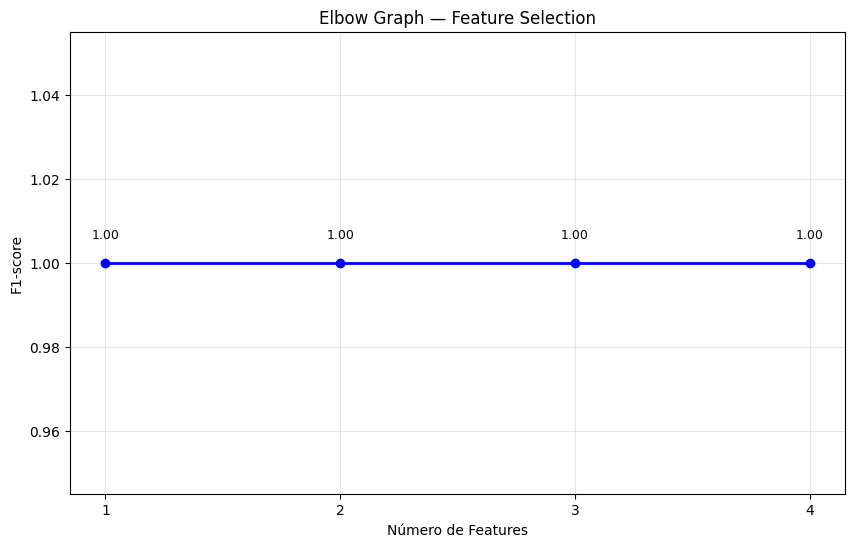

In [105]:
import matplotlib.pyplot as plt
import numpy as np



ks = np.arange(1, len(f1s)+1)  # número de features

plt.figure(figsize=(10,6))
plt.plot(ks, f1s, marker='o', linewidth=2, color='blue')
plt.title("Elbow Graph — Feature Selection")
plt.xlabel("Número de Features")
plt.ylabel("F1-score")
plt.xticks(ks)
plt.grid(True, alpha=0.3)

# Opcional: mostrar os valores de F1 acima dos pontos
for x, y in zip(ks, f1s):
    plt.text(x, y+0.005, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.show()
